In [1]:
# https://lmfit.github.io/lmfit-py/examples/example_emcee_Model_interface.html

In [2]:
import corner
import matplotlib.pyplot as plt
import numpy as np

import lmfit

In [3]:
def double_exp(x, a1, t1, a2, t2):
    return a1*np.exp(-x/t1) + a2*np.exp(-(x-0.1) / t2)


model = lmfit.Model(double_exp)

In [4]:
truths = (3.0, 2.0, -5.0, 10.0)
x = np.linspace(1, 10, 250)
np.random.seed(0)
y = double_exp(x, *truths)+0.1*np.random.randn(x.size)

In [5]:
p = model.make_params(a1=4, t1=3, a2=4, t2=3)


[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 609
    # data points      = 250
    # variables        = 4
    chi-square         = 2.33333982
    reduced chi-square = 0.00948512
    Akaike info crit   = -1160.54007
    Bayesian info crit = -1146.45423
[[Variables]]
    a1:  2.98623689 +/- 0.15010519 (5.03%) (init = 4)
    t1:  1.30993186 +/- 0.13449652 (10.27%) (init = 3)
    a2: -4.33525597 +/- 0.11765819 (2.71%) (init = 4)
    t2:  11.8099125 +/- 0.47172590 (3.99%) (init = 3)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, t2) =  0.988
    C(t1, a2) = -0.928
    C(t1, t2) = -0.885
    C(a1, t1) = -0.609
    C(a1, a2) =  0.297
    C(a1, t2) =  0.232


/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/lmfit/minimizer.py:176: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

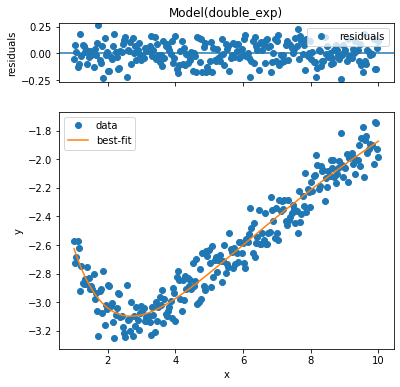

In [6]:
result = model.fit(data=y, params=p, x=x, method='Nelder', nan_policy='omit')

lmfit.report_fit(result)
result.plot()

In [7]:
# mcmc

In [8]:
emcee_kws = dict(steps=1000, burn=300, thin=20, is_weighted=False)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 250
    # variables        = 5
    chi-square         = 246.023408
    reduced chi-square = 1.00417717
    Akaike info crit   = 5.99144165
    Bayesian info crit = 23.5987462
[[Variables]]
    a1:         2.99771611 +/- 0.15012839 (5.01%) (init = 2.986237)
    t1:         1.31055676 +/- 0.14335880 (10.94%) (init = 1.309932)
    a2:        -4.33409440 +/- 0.12678018 (2.93%) (init = -4.335256)
    t2:         11.8407571 +/- 0.49634903 (4.19%) (init = 11.80991)
    __lnsigma: -2.32884140 +/- 0.04460138 (1.92%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, t2) =  0.982
    C(t1, a2) = -0.938
    C(t1, t2) = -0.895
    C(a1, t1) = -0.537
    C(a1, a2) =  0.247
    C(a1, t2) =  0.206


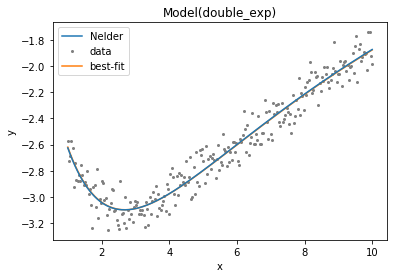

In [9]:
result_emcee = model.fit(data=y, x=x, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)

lmfit.report_fit(result_emcee)

ax = plt.plot(x, model.eval(params=result.params, x=x), label='Nelder', zorder=100)
result_emcee.plot_fit(ax=ax, data_kws=dict(color='gray', markersize=2))
plt.show()

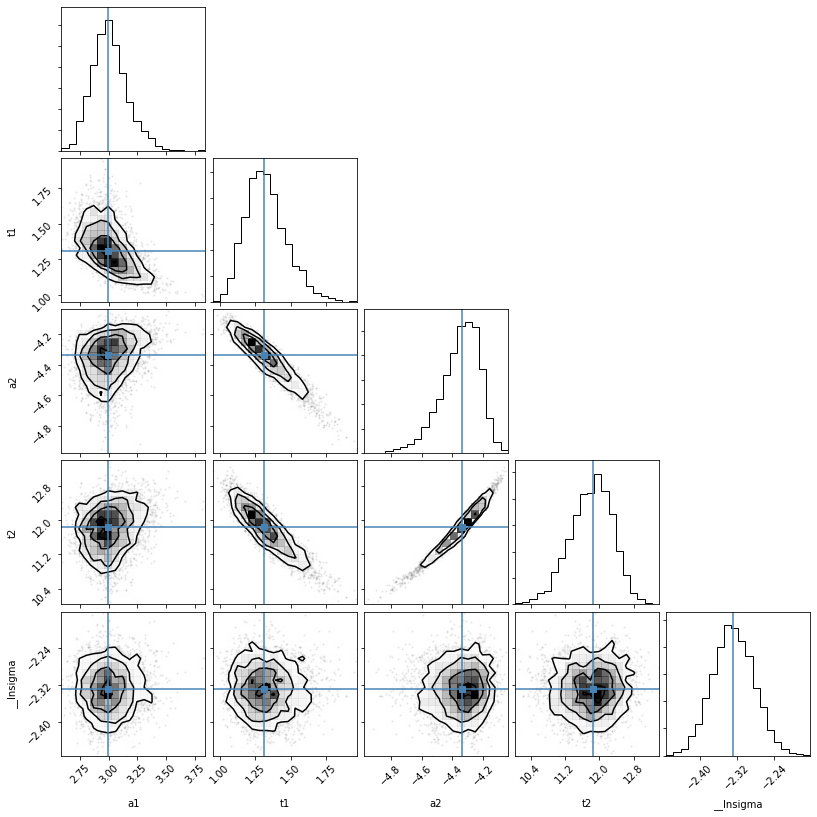

In [10]:
emcee_corner = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names,
                             truths=list(result_emcee.params.valuesdict().values()))

In [11]:
print("\nmedian of posterior probability distribution")
print('--------------------------------------------')
lmfit.report_fit(result_emcee.params)

# find the maximum likelihood solution
highest_prob = np.argmax(result_emcee.lnprob)
hp_loc = np.unravel_index(highest_prob, result_emcee.lnprob.shape)
mle_soln = result_emcee.chain[hp_loc]
print("\nMaximum likelihood Estimation")
print('-----------------------------')
for ix, param in enumerate(emcee_params):
    print(param + ': ' + str(mle_soln[ix]))

quantiles = np.percentile(result_emcee.flatchain['t1'], [2.28, 15.9, 50, 84.2, 97.7])
print("\n\n1 sigma spread", 0.5 * (quantiles[3] - quantiles[1]))
print("2 sigma spread", 0.5 * (quantiles[4] - quantiles[0]))


median of posterior probability distribution
--------------------------------------------
[[Variables]]
    a1:         2.99771611 +/- 0.15012839 (5.01%) (init = 2.986237)
    t1:         1.31055676 +/- 0.14335880 (10.94%) (init = 1.309932)
    a2:        -4.33409440 +/- 0.12678018 (2.93%) (init = -4.335256)
    t2:         11.8407571 +/- 0.49634903 (4.19%) (init = 11.80991)
    __lnsigma: -2.32884140 +/- 0.04460138 (1.92%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, t2) =  0.982
    C(t1, a2) = -0.938
    C(t1, t2) = -0.895
    C(a1, t1) = -0.537
    C(a1, a2) =  0.247
    C(a1, t2) =  0.206

Maximum likelihood Estimation
-----------------------------
a1: 2.997192961466527
t1: 1.314357493831943
a2: -4.341567925750617
t2: 11.806136002002985
__lnsigma: -2.323960237417992


1 sigma spread 0.14375477512967405
2 sigma spread 0.29217229817969304
